<a href="https://colab.research.google.com/github/VitikaJain25/GenAI/blob/main/Youtube_Video_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

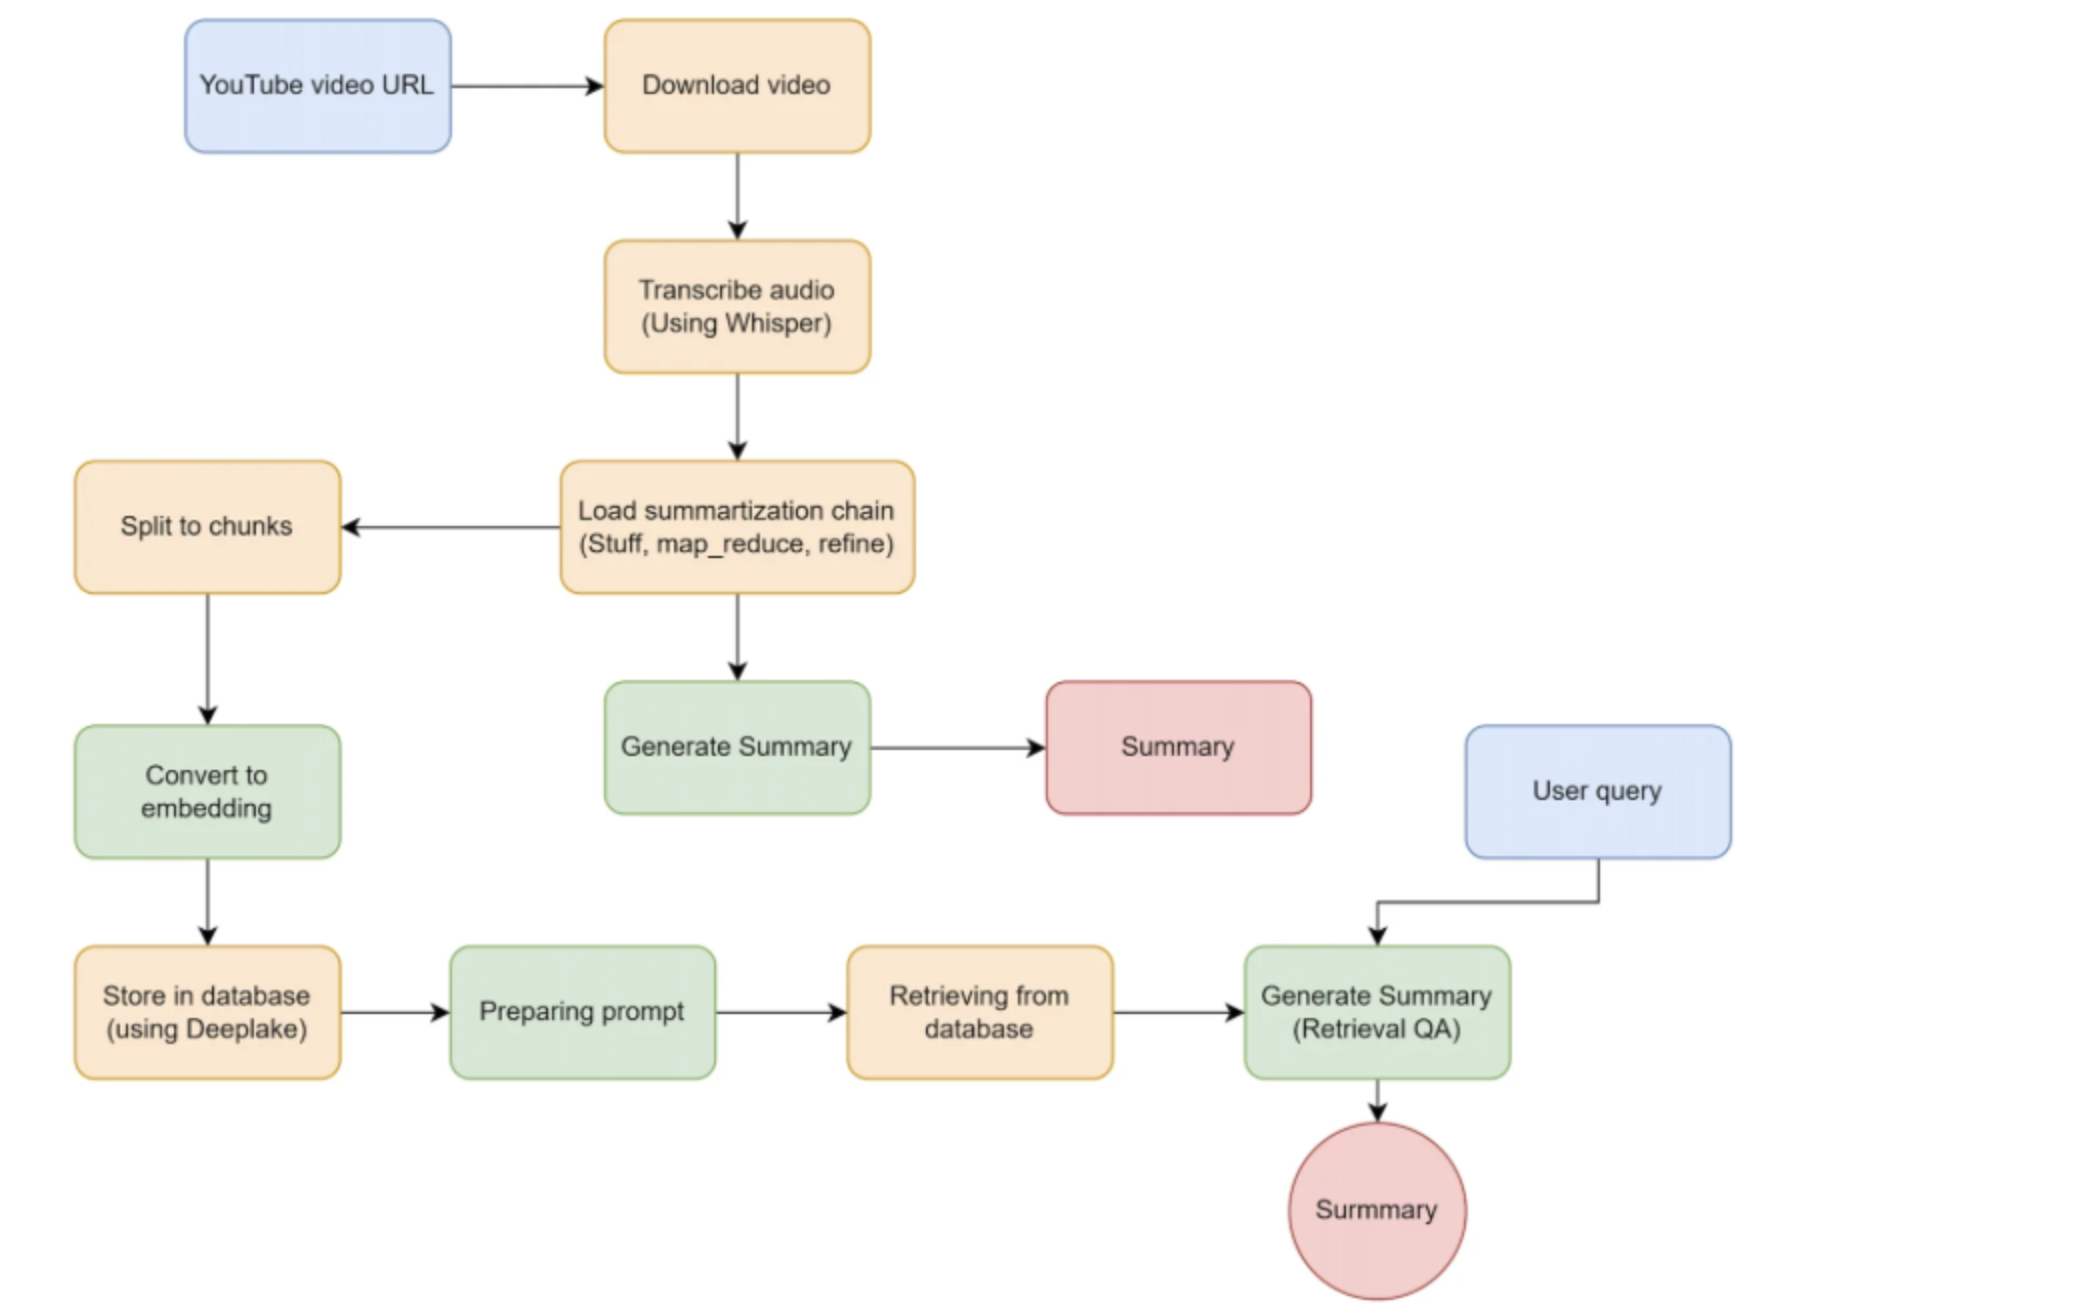

First, we download the youtube video we are interested in and transcribe it using **Whisper**. Then, we’ll proceed by creating summaries using two different approaches:

First we use an existing summarization chain to generate the final summary, which automatically manages embeddings and prompts.

Then, we use another approach more step-by-step to generate a final summary formatted in bullet points, consisting in splitting the transcription into chunks, computing their embeddings, and preparing ad-hoc prompts.

**WORKFLOW**:




1.   Download the YouTube audio file.
2.   Transcribe the audio using Whisper.
3.   Summarize the transcribed text using LangChain with three different approaches: stuff, refine, and map_reduce.
4.   Adding multiple URLs to DeepLake database, and retrieving information.








In [ ]:
pip install langchain==0.1.4 deeplake openai==1.10.0 tiktoken

In [ ]:
!pip install -q yt_dlp
!pip install -q git+https://github.com/openai/whisper.git

In [ ]:
import os

In [ ]:
os.environ["OPENAI_API_KEY"] = ""
os.environ['ACTIVELOOP_TOKEN'] = ""

## Download the video

In [ ]:
import yt_dlp

The download_mp4_from_youtube() function will download the best quality mp4 video file from any YouTube link and save it to the specified path and filename.

In [ ]:
def download_mp4_from_youtube(url):
    # Set the options for the download
    filename = 'lecuninterview.mp4'
    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]',
        'outtmpl': filename,
        'quiet': True,
    }

    # Download the video file
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        result = ydl.extract_info(url, download=True)

In [ ]:
url = "https://www.youtube.com/watch?v=mBjPyte2ZZo"

In [ ]:
download_mp4_from_youtube(url)

## Transcribe using Whisper

In [ ]:
import whisper

In [ ]:
# Using the base model
model = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 83.0MiB/s]


In [ ]:
result = model.transcribe("lecuninterview.mp4")

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [ ]:
print(result['text'])

 Hi, I'm Craig Smith and this is I on A On. This week I talked to Jan LeCoon, one of the seminal figures in deep learning development and a long time proponent of self-supervised learning. Jan spoke about what's missing in large language models and about his new joint embedding predictive architecture which may be a step toward filling that gap. He also talked about his theory of consciousness and the potential for AI systems to someday exhibit the features of consciousness. It's a fascinating conversation that I hope you'll enjoy. Okay, so Jan, it's great to see you again. I wanted to talk to you about where you've gone with so supervised learning since last week spoke. In particular, I'm interested in how it relates to large language models because the large language models really came on stream since we spoke. In fact, in your talk about JEPA, which is joint embedding predictive architecture. There you go. Thank you. You mentioned that large language models lack a world model. I wan

In [ ]:
with open ('text.txt', 'w') as file:
    file.write(result['text'])

## Summarization with LangChain

In [ ]:
from langchain import OpenAI, LLMChain
from langchain.chains.mapreduce import MapReduceChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain

In [ ]:
llm = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=0, separators=[" ", ",", "\n"]
)

In [ ]:
from langchain.docstore.document import Document

In [ ]:
with open('text.txt') as f:
    text = f.read()

In [ ]:
texts = text_splitter.split_text(text)

In [ ]:
# Each Document object is initialized with the content of a chunk from the texts list.
# The [:4] slice notation indicates that only the first four chunks will be used to create the Document objects.
docs = [Document(page_content=t) for t in texts[:4]]

### map_reduce Approach for summarization

In [ ]:
from langchain.chains.summarize import load_summarize_chain
import textwrap

In [ ]:
chain = load_summarize_chain(llm, chain_type="map_reduce")

In [ ]:
output_summary = chain.run(docs)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [ ]:
print(output_summary)



Craig Smith interviews Jan LeCoon, a leading figure in deep learning and self-supervised learning. They discuss Jan's new joint embedding predictive architecture and its potential to fill the gap in large language models. Jan also shares his thoughts on consciousness and the potential for AI systems to exhibit its features. They also touch on the impact of self-supervised learning on natural language processing and its use in transformer architectures. They discuss the challenges of representing uncertainty in generative models and its application to other forms of media.


In [ ]:
# The textwrap library in Python provides a convenient way to wrap and format plain text by
# adjusting line breaks in an input paragraph.
wrapped_text = textwrap.fill(output_summary, width=100)

In [ ]:
print(wrapped_text)

  Craig Smith interviews Jan LeCoon, a leading figure in deep learning and self-supervised learning.
They discuss Jan's new joint embedding predictive architecture and its potential to fill the gap in
large language models. Jan also shares his thoughts on consciousness and the potential for AI
systems to exhibit its features. They also touch on the impact of self-supervised learning on
natural language processing and its use in transformer architectures. They discuss the challenges of
representing uncertainty in generative models and its application to other forms of media.


With the following line of code, we can see the prompt template that is used with the map_reduce technique.

Now we’re changing the prompt and using another summarization method:

In [ ]:
print( chain.llm_chain.prompt.template )

Write a concise summary of the following:


"{text}"


CONCISE SUMMARY:


### Stuff approach for summarization

The "stuff" approach is the simplest and most naive one, in which all the text from the transcribed video is used in a single prompt.

This method may raise exceptions if all text is longer than the available context size of the LLM and may not be the most efficient way to handle large amounts of text.

In [ ]:
prompt_template = """Write a concise bullet point summary of the following:


{text}


CONSCISE SUMMARY IN BULLET POINTS:"""

In [ ]:
BULLET_POINT_PROMPT = PromptTemplate(template=prompt_template,
                        input_variables=["text"])

In [ ]:
# initializing the summarization chain using the stuff as chain_type.
chain = load_summarize_chain(llm,
                             chain_type="stuff",
                             prompt=BULLET_POINT_PROMPT)

In [ ]:
output_summary = chain.run(docs)

In [ ]:
wrapped_text = textwrap.fill(output_summary,
                             width=1000,
                             break_long_words=False,
                             replace_whitespace=False)

In [ ]:
print(wrapped_text)

 

- Craig Smith interviews Jan LeCoon, a leading figure in deep learning and self-supervised learning
- Jan discusses his new joint embedding predictive architecture and its potential to fill gaps in large language models
- He also talks about his theory of consciousness and the potential for AI systems to exhibit conscious features
- Jan is a professor at New York University and the chief AI scientist at Fair, a fundamental AI research lab
- Self-supervised learning has revolutionized natural language processing, particularly in pre-training transformer architectures
- Large language models lack a world model and struggle with representing uncertain predictions
- Jan's joint embedding predictive architecture aims to address these issues and improve the performance of large language models
- The interview covers the trajectory of Jan's research in self-supervised learning and its relation to large language models.


### refine approach for summarization

The 'refine' summarization chain is a method for generating more accurate and context-aware summaries.

This chain type is designed to iteratively refine the summary by providing additional context when needed.

That means: it generates the summary of the first chunk

Then, for each successive chunk, the work-in-progress summary is integrated with new info from the new chunk.

In [ ]:
chain = load_summarize_chain(llm, chain_type="refine")

In [ ]:
output_summary = chain.run(docs)

In [ ]:
wrapped_text = textwrap.fill(output_summary, width=100)

In [ ]:
print(wrapped_text)

 Craig Smith interviews Jan LeCoon, a leading figure in deep learning and self-supervised learning.
They discuss Jan's new joint embedding predictive architecture and its potential to improve large
language models. Jan also shares his thoughts on consciousness and the potential for AI systems to
exhibit its features. Jan is a professor at New York University and the Quarantine Institute, as
well as the chief AI scientist at Fair, a fundamental AI research lab at Facebook. He explains how
self-supervised learning has revolutionized natural language processing and the use of transformer
architectures for pre-training. The joint embedding predictive architecture is a continuation of his
research in this field and has the potential to address the limitations of large language models.
Jan also discusses the practical applications of self-supervised learning, such as contact
moderation systems on social media platforms, and the potential for large language models to predict
the next word in 

The 'refine' summarization chain in LangChain provides a flexible and iterative approach to generating summaries, allowing you to customize prompts and provide additional context for refining the output.

This method can result in more accurate and context-aware summaries compared to other chain types like 'stuff' and 'map_reduce'.

## Adding Transcripts to Deep Lake

This method can be extremely useful when you have more data.

Adding multiple URLs, store them in Deep Lake database and retrieve information using QA chain.

In [ ]:
import yt_dlp

In [ ]:
def download_mp4_from_youtube(urls, job_id):
    # This will hold the titles and authors of each downloaded video
    video_info = []

    for i, url in enumerate(urls):
        # Set the options for the download
        file_temp = f'./{job_id}_{i}.mp4'
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]',
            'outtmpl': file_temp,
            'quiet': True,
        }

        # Download the video file
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            result = ydl.extract_info(url, download=True)
            title = result.get('title', "")
            author = result.get('uploader', "")

        # Add the title and author to our list
        video_info.append((file_temp, title, author))

    return video_info

In [ ]:
urls=["https://www.youtube.com/watch?v=mBjPyte2ZZo&t=78s",
    "https://www.youtube.com/watch?v=cjs7QKJNVYM",]

In [ ]:
video_details = download_mp4_from_youtube(urls, 1)


And transcribe the videos using Whisper as we previously saw and save the results in a text file.

In [ ]:
import whisper

In [ ]:
# load the model
model = whisper.load_model("base")

In [ ]:
# iterate through each video and transcribe
results = []
for video in video_details:
    result = model.transcribe(video[0])
    results.append(result['text'])
    print(f"Transcription for {video[0]}:\n{result['text']}\n")

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription for ./1_0.mp4:
 Hi, I'm Craig Smith and this is I on A On. This week I talked to Jan LeCoon, one of the seminal figures in deep learning development and a long time proponent of self-supervised learning. Jan spoke about what's missing in large language models and about his new joint embedding predictive architecture which may be a step toward filling that gap. He also talked about his theory of consciousness and the potential for AI systems to someday exhibit the features of consciousness. It's a fascinating conversation that I hope you'll enjoy. Okay, so Jan, it's great to see you again. I wanted to talk to you about where you've gone with so supervised learning since last week spoke. In particular, I'm interested in how it relates to large language models because the large language models really came on stream since we spoke. In fact, in your talk about JEPA, which is joint embedding predictive architecture. There you go. Thank you. You mentioned that large language mod

/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcription for ./1_1.mp4:
 Hello, it's Yannick from the future. AI is moving crazy fast right now, like crazy. So the news of this week is like old news, but I'm still going to show to you. Google I.O. just recently happened. The gist of it is they're going to stick generative AI into just about everything. And also, Anthropic releases upgrades the Claude API to have a hundred thousand tokens context. No one knows so far how they're doing it, but it's happening. A hundred thousand tokens context insane. All right, enjoy the news. Yay. Jeff Hinton leaves Google and tells the world about the dangers of AI. Open AI loses half a billion dollars and Google has no mouth. Welcome to ML News. Hello, everyone. Welcome to ML News. Let's dive right in lots of stuff happening. This is Snapchat AI. Do you have access to my location? No, I don't have access to your location. Where am I? I'm sorry, but I don't have access to your location information. Okay, are you lying? No, I'm not lying. I don'

In [ ]:
with open('text_1.txt', 'w') as file:
  file.write(results[0])

In [ ]:
with open('text_1.txt', 'a') as file:
  file.write(results[1])

Then, load the texts from the file and use the text splitter to split the text to chunks with zero overlap before we store them in Deep Lake.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [ ]:
# Load the texts
with open('text_1.txt') as f:
    text = f.read()

In [ ]:
texts = text_splitter.split_text(text)

In [ ]:
# Split the documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=0, separators=[" ", ",", "\n"]
    )

In [ ]:
texts = text_splitter.split_text(text)

# Similarly, as before we’ll pack all the chunks into a Documents:

In [ ]:
from langchain.docstore.document import Document

In [ ]:
docs = [Document(page_content=t) for t in texts[:4]]

Now, we’re ready to import Deep Lake and build a database with embedded documents:

In [ ]:
from langchain.vectorstores import DeepLake
from langchain.embeddings.openai import OpenAIEmbeddings

In [ ]:
embeddings = OpenAIEmbeddings(model='text-embedding-ada-002')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.openai.OpenAIEmbeddings` was deprecated in langchain-community 0.1.0 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
# create Deep Lake dataset
my_activeloop_org_id = ""
my_activeloop_dataset_name = "langchain_course_youtube_summarizer"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"

In [ ]:
db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

Your Deep Lake dataset has been successfully created!


In [ ]:
db.add_documents(docs)

In order to retrieve the information from the database, we’d have to construct a retriever object.

The distance metric determines how the Retriever measures "distance" or similarity between different data points in the database.

By setting distance_metric to 'cos', the Retriever will use cosine similarity as its distance metric. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.

It's often used in information retrieval to measure the similarity between documents or pieces of text.

'k' to 4, the Retriever will return the 4 most similar or closest results according to the distance metric when a search is performed.

In [ ]:
retriever = db.as_retriever()

In [ ]:
retriever.search_kwargs['distance_metric'] = 'cos'

In [ ]:
retriever.search_kwargs['k'] = 4

We can construct and use a custom prompt template with the QA chain. The RetrievalQA chain is useful to query similiar contents from databse and use the returned records as context to answer questions. The custom prompt ability gives us the flexibility to define custom tasks like retrieving the documents and summaizing the results in a bullet-point style.

In [ ]:
from langchain.prompts import PromptTemplate

In [ ]:
prompt_template = """Use the following pieces of transcripts from a video to answer the question in bullet points and summarized. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Summarized answer in bullter points:"""

In [ ]:
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

Lastly, we can use the chain_type_kwargs argument to define the custom prompt and for chain type the ‘stuff’  variation was picked. You can perform and test other types as well, as seen previously.

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
chain_type_kwargs = {"prompt": PROMPT}

In [ ]:
qa = RetrievalQA.from_chain_type(llm=llm,
                                 chain_type="stuff",
                                 retriever=retriever,
                                 chain_type_kwargs=chain_type_kwargs)

In [ ]:
print(qa.run("Summarize the mentions of google according to their AI program"))

 
- Google uses self-supervised learning in their AI programs
- They use a technique where they remove words from text and train a neural net to predict the missing words
- This has been a major revolution in the field of natural language processing
- Google's AI programs, such as contact moderation systems, use this technique
- Google is also exploring the use of large language models and generative models in their AI programs
- However, there are challenges in representing uncertainty in predictions for non-text data, such as video.
